# ResNet

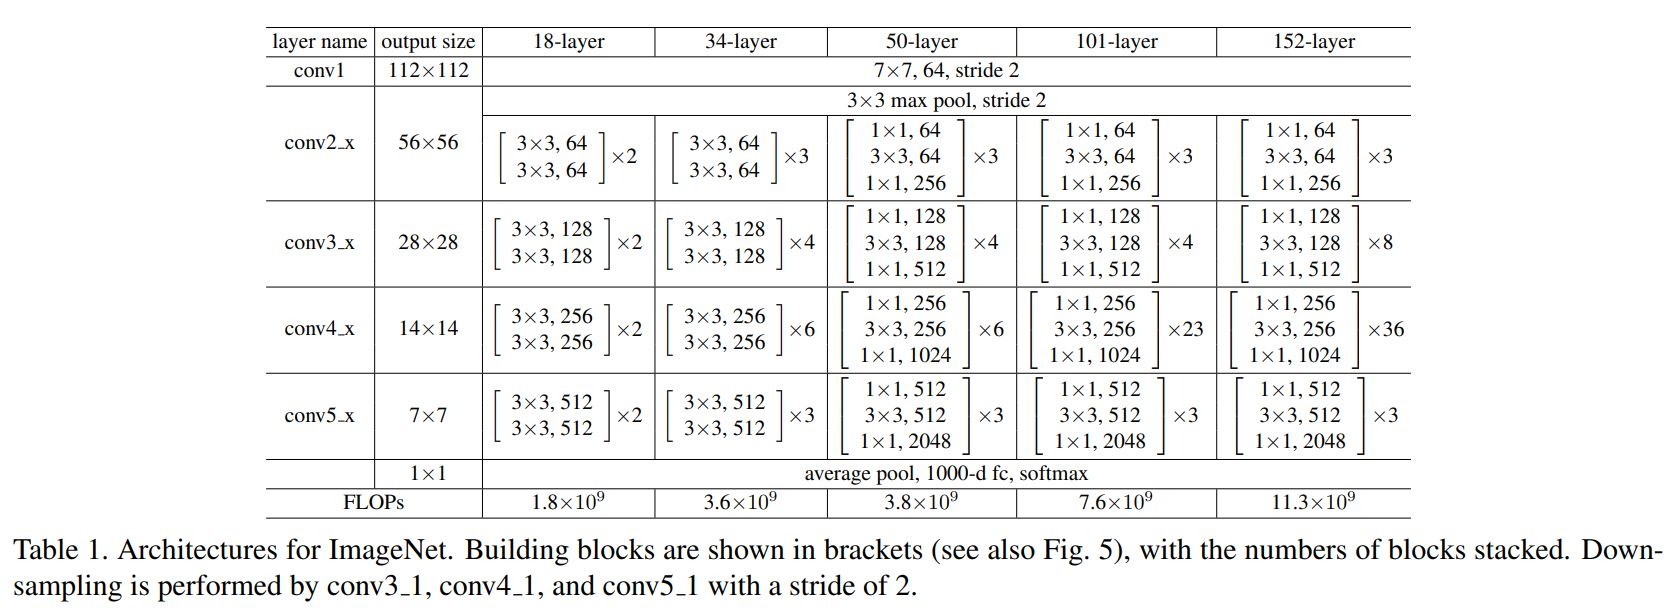

ResNet은 basic block을 연속적으로 여러개를 쌓아 코드를 작성함.
\begin{bmatrix}
3\times3, 64\\ 
3\times3, 64
\end{bmatrix}
위 하나의 block은 2개의 conv block으로 구성되어 있음.  
하나의 layer를 거친 결과가 batch normalization, Relu를 거친 후에 다음 layer에 들어가는 것을 확인할 수 있음. 

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. ResNet 블록 구성하기

In [2]:
# function for building ResNet Block
def build_ResNet_block(input_layer ,num_cnn=2,stage_num=2, stride = 1, channel=64, is_50=False):
    x = input_layer
    short = x
        
    if not is_50:
        if stage_num >2:
            short = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        strides=2,
                                        name=f'stage{stage_num}_conv1',
                                        )(short)
            short = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn1')(short)
        for cnn_num in range(num_cnn):
            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)                    

            x = keras.layers.Add()([x, short])
            x = keras.layers.Activation('relu')(x)    
            short = x
    
    else:
        if stage_num == 2:
            strides = 1
        else:
            strides = 2
        short = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1, 1),
                                    padding='same',
                                    strides=strides,
                                    name=f'stage{stage_num}_conv1',
                                    )(short)
        short = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn1')(short)
        
        for cnn_num in range(num_cnn):

            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)                    
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU2')(x)
            
            # 3rd layer
            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1,1),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)                    

            x = keras.layers.Add()([x, short])
            x = keras.layers.Activation('relu')(x)    
            short = x   
    return x

## 2. ResNet Complete Model

In [3]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(224, 224, 3), is_50=False):
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 10  # 데이터 셋이 cifar10이기 때문에 num_classes를 10으로 변경
    
    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x) 
    x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x) 
    output = x
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_ResNet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                )
        
    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

### (1) ResNet - 34

In [4]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

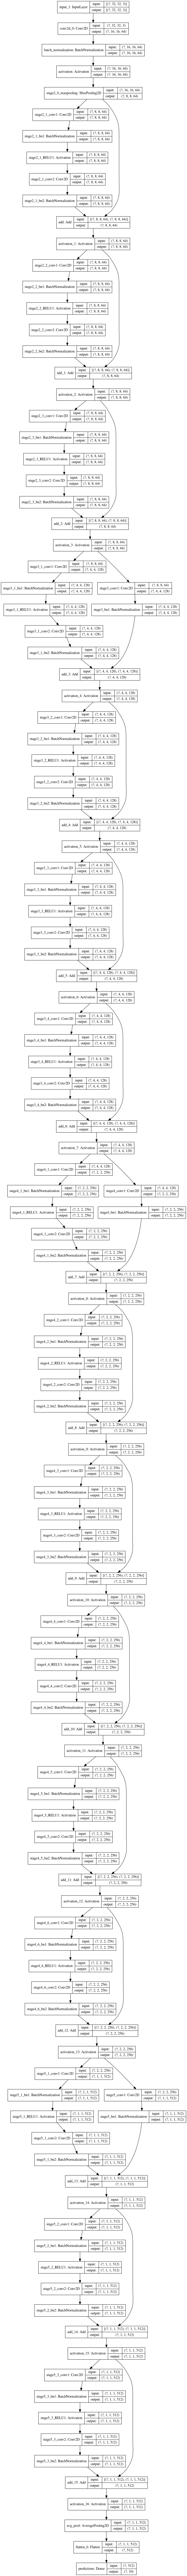

In [5]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(resnet_34, to_file="resnet_34.png", show_shapes=True)

### (2) ResNet - 50

In [6]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

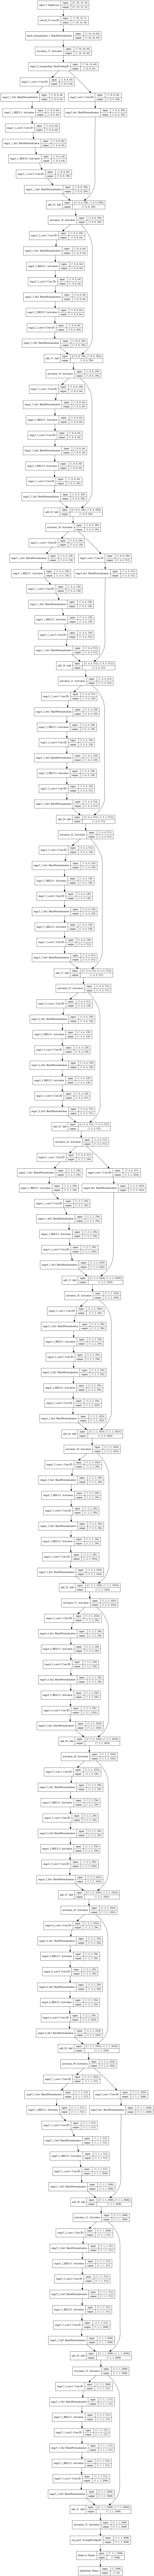

In [7]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(resnet_50, to_file="resnet_50.png", show_shapes=True)

# PlainNet

## 1. PlainNet 블록 구성하기

In [8]:
# function for building Plain Network Block
def build_Plain_block(input_layer ,num_cnn=2,stage_num=2, stride = 1, channel=64, is_50=False):
    x = input_layer
    
    if not is_50:
        for cnn_num in range(num_cnn):
            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)                    
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU2')(x)
            
    else:    
        for cnn_num in range(num_cnn):
            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)                    
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU2')(x)
            
            # 3rd layer
            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1,1),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)                    
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU3')(x)
            
    return x

## 2. PlainNet Complete Model

In [9]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_PlainNet(input_shape=(224, 224, 3), is_50=False):
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 2 # 데이터 셋이 cats vs dogs이기 때문에 num_classes를 2로 변경
    
    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x) 
    x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x) 
    output = x
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_Plain_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                )
        
    #output = keras.layers.Activation('relu')(output)
    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

### (1) Plain - 34

In [10]:
plain_34 = build_PlainNet(input_shape=(224, 224,3), is_50=False)
plain_34.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_34 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)       

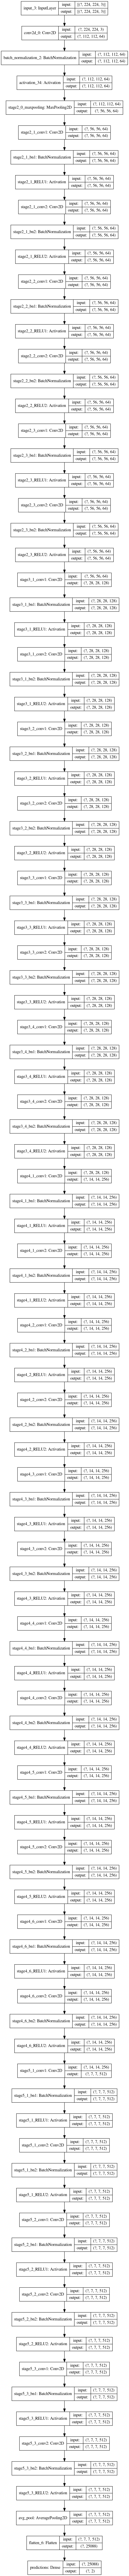

In [11]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(plain_34, to_file="plain_34.png", show_shapes=True)

### (2) Plain - 50

In [12]:
plain_50 = build_PlainNet(input_shape=(224, 224,3), is_50=True)
plain_50.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_35 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)       

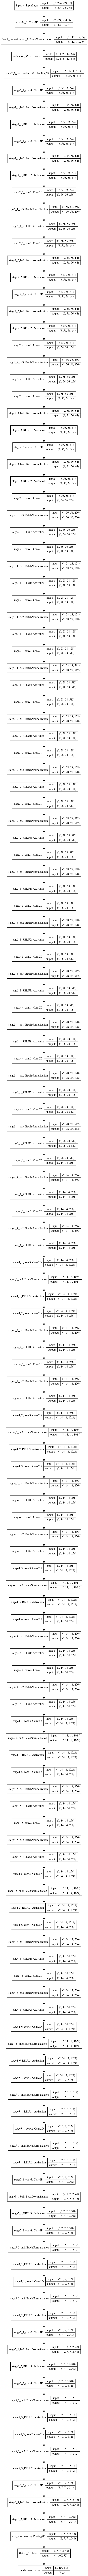

In [13]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(plain_50, to_file="plain_50.png", show_shapes=True)

# 데이터셋 준비하기

## 1. Load DataSet & Input Normalization

In [14]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:35%]','train[20%:]' ],
    shuffle_files=True,
    with_info=True,
    as_supervised = True 
)


참고 : https://katie0809.github.io/2020/07/25/tf-study6/
as_supervised 옵션을 True로 주면 데이터가 튜플로 반환된다. 
False일 경우 dictionary 형태로 반환된다. => default 값은 False.

In [15]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [16]:
ds_info.features['label'].names

['cat', 'dog']

In [17]:
ds_train_shape = tf.data.experimental.cardinality(ds_train)
ds_test_shape = tf.data.experimental.cardinality(ds_test)

print(ds_train_shape)
print(ds_test_shape)

tf.Tensor(8142, shape=(), dtype=int64)
tf.Tensor(18610, shape=(), dtype=int64)


In [18]:
def normalize_and_resize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (224,224))
    return image, label

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds= ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# ResNet Ablation Study

In [20]:
BATCH_SIZE = 16
EPOCH = 10

In [21]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## 1. ResNet-34 vs Plain-34

In [22]:
# Cat vs Dog 데이터 셋에 맞춰서 input shape 변경
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False)

In [23]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01,momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)


history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape/BATCH_SIZE),
    validation_steps=int(ds_test_shape/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
508/508 [==============================] - 66s 129ms/step - loss: 1.9397 - accuracy: 0.5244 - val_loss: 0.7641 - val_accuracy: 0.5286
Epoch 2/10
508/508 [==============================] - 65s 128ms/step - loss: 1.2300 - accuracy: 0.5525 - val_loss: 0.8330 - val_accuracy: 0.5425
Epoch 3/10
508/508 [==============================] - 65s 128ms/step - loss: 1.0250 - accuracy: 0.6079 - val_loss: 2.2442 - val_accuracy: 0.6308
Epoch 4/10
508/508 [==============================] - 65s 128ms/step - loss: 0.8863 - accuracy: 0.6487 - val_loss: 2.4856 - val_accuracy: 0.6354
Epoch 5/10
508/508 [==============================] - 65s 128ms/step - loss: 0.7815 - accuracy: 0.6701 - val_loss: 0.6362 - val_accuracy: 0.6722
Epoch 6/10
508/508 [==============================] - 65s 128ms/step - loss: 0.6370 - accuracy: 0.6948 - val_loss: 0.7419 - val_accuracy: 0.6967
Epoch 7/10
508/508 [==============================] - 65s 128ms/step - loss: 0.5696 - accuracy: 0.7122 - val_loss: 0.7037 - val_ac

In [24]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01,momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

plain_history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape/BATCH_SIZE),
    validation_steps=int(ds_test_shape/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
508/508 [==============================] - 63s 123ms/step - loss: 1.2190 - accuracy: 0.5069 - val_loss: 201.1027 - val_accuracy: 0.5238
Epoch 2/10
508/508 [==============================] - 62s 123ms/step - loss: 1.1819 - accuracy: 0.5052 - val_loss: 15.2763 - val_accuracy: 0.4969
Epoch 3/10
508/508 [==============================] - 62s 123ms/step - loss: 1.0002 - accuracy: 0.4964 - val_loss: 353.0107 - val_accuracy: 0.5042
Epoch 4/10
508/508 [==============================] - 62s 122ms/step - loss: 0.8090 - accuracy: 0.5084 - val_loss: 0.6932 - val_accuracy: 0.5043
Epoch 5/10
508/508 [==============================] - 62s 122ms/step - loss: 0.6999 - accuracy: 0.5098 - val_loss: 0.7027 - val_accuracy: 0.5032
Epoch 6/10
508/508 [==============================] - 62s 123ms/step - loss: 0.6948 - accuracy: 0.5001 - val_loss: 0.6950 - val_accuracy: 0.5036
Epoch 7/10
508/508 [==============================] - 62s 123ms/step - loss: 0.6962 - accuracy: 0.5053 - val_loss: 0.7054 - v

#### 결과

In [25]:
import pandas as pd 
result = pd.DataFrame({ 'ResNet - 34' : history_34.history['val_loss'],
                       'PlainNet - 34' : plain_history_34.history['val_loss']    
})
result.transpose()

0          1           2         3         4  \
ResNet - 34      0.764133   0.832952    2.244210  2.485588  0.636219   
PlainNet - 34  201.102707  15.276254  353.010681  0.693182  0.702694   

                      5         6         7         8         9  
ResNet - 34    0.741939  0.703722  0.883637  0.999154  0.708349  
PlainNet - 34  0.694989  0.705389  0.694814  0.693575  0.919768

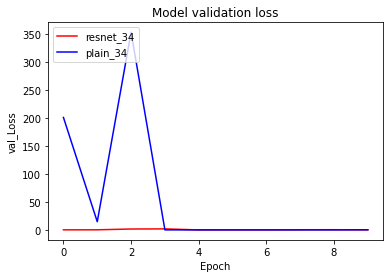

In [26]:
import matplotlib.pyplot as plt

# validation loss 시각화
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(plain_history_34.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('val_Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

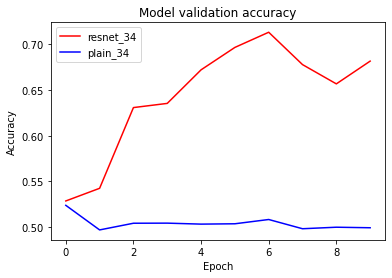

In [27]:
# validation accuracy 시각화
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(plain_history_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

## 2.  ResNet-50 vs Plain-50

In [28]:
# Cat vs Dog 데이터 셋에 맞춰서 input shape 변경
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True)

In [29]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01,momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)


history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape/BATCH_SIZE),
    validation_steps=int(ds_test_shape/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
508/508 [==============================] - 107s 210ms/step - loss: 3.1861 - accuracy: 0.5167 - val_loss: 3.6278 - val_accuracy: 0.4992
Epoch 2/10
508/508 [==============================] - 106s 209ms/step - loss: 2.2219 - accuracy: 0.5516 - val_loss: 10.6304 - val_accuracy: 0.5715
Epoch 3/10
508/508 [==============================] - 106s 209ms/step - loss: 1.9570 - accuracy: 0.5758 - val_loss: 1076.1536 - val_accuracy: 0.5064
Epoch 4/10
508/508 [==============================] - 106s 209ms/step - loss: 1.7003 - accuracy: 0.5727 - val_loss: 96.4587 - val_accuracy: 0.5009
Epoch 5/10
508/508 [==============================] - 106s 210ms/step - loss: 1.5434 - accuracy: 0.5809 - val_loss: 0.6817 - val_accuracy: 0.5862
Epoch 6/10
508/508 [==============================] - 106s 209ms/step - loss: 1.4443 - accuracy: 0.5605 - val_loss: 15.5644 - val_accuracy: 0.5494
Epoch 7/10
508/508 [==============================] - 106s 209ms/step - loss: 1.1680 - accuracy: 0.5852 - val_loss: 17

In [30]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01,momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

plain_history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape/BATCH_SIZE),
    validation_steps=int(ds_test_shape/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
508/508 [==============================] - 93s 183ms/step - loss: 1.9739 - accuracy: 0.5014 - val_loss: 0.9160 - val_accuracy: 0.4942
Epoch 2/10
508/508 [==============================] - 90s 177ms/step - loss: 1.9352 - accuracy: 0.4964 - val_loss: 301.3420 - val_accuracy: 0.5090
Epoch 3/10
508/508 [==============================] - 90s 177ms/step - loss: 1.6854 - accuracy: 0.5062 - val_loss: 0.7220 - val_accuracy: 0.5118
Epoch 4/10
508/508 [==============================] - 90s 177ms/step - loss: 1.6674 - accuracy: 0.5178 - val_loss: 1.2088 - val_accuracy: 0.5008
Epoch 5/10
508/508 [==============================] - 90s 177ms/step - loss: 1.4455 - accuracy: 0.5052 - val_loss: 36.2468 - val_accuracy: 0.5019
Epoch 6/10
508/508 [==============================] - 90s 177ms/step - loss: 1.2435 - accuracy: 0.5091 - val_loss: 4.0447 - val_accuracy: 0.5427
Epoch 7/10
508/508 [==============================] - 90s 176ms/step - loss: 0.9445 - accuracy: 0.5281 - val_loss: 1.1876 - val

#### 결과

In [33]:
import pandas as pd 
result = pd.DataFrame({ 'ResNet - 34' : history_50.history['val_loss'],
                       'PlainNet - 34' : plain_history_50.history['val_loss']    
})
result.transpose()

0           1            2          3          4  \
ResNet - 34    3.627812   10.630395  1076.153564  96.458679   0.681722   
PlainNet - 34  0.916019  301.342041     0.721966   1.208827  36.246799   

                       5          6         7         8         9  
ResNet - 34    15.564381  17.418715  5.859415  1.579307  0.796631  
PlainNet - 34   4.044737   1.187638  0.717714  0.703900  0.747612

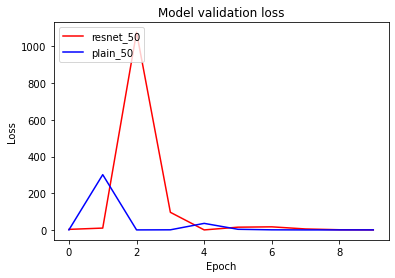

In [34]:
# validation loss 시각화
plt.plot(history_50.history['val_loss'], 'r')
plt.plot(plain_history_50.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

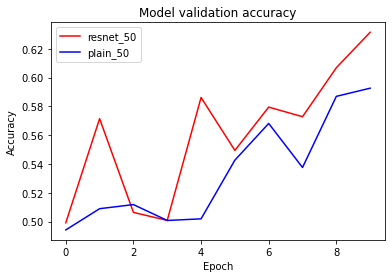

In [35]:
# validation accuracy 시각화
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(plain_history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()